# HANDWRITTEN DIGITS AND CHARACTER IDENTIFICATION

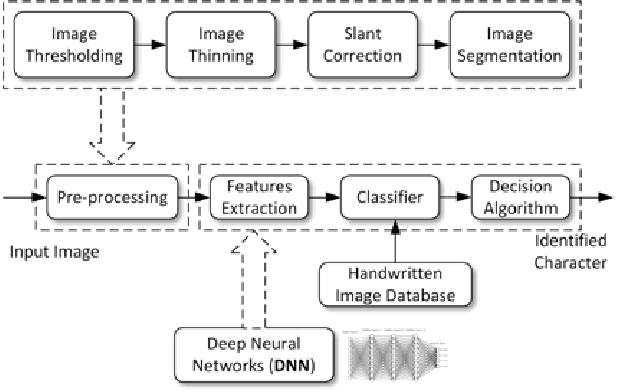

# Installing kaggle

In [ ]:
pip install kaggle


# Downloading the datasets

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhuvaneswarijo","key":"68afe1030cccfeb5575259f68eef8f75"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d crawford/emnist

Dataset URL: https://www.kaggle.com/datasets/crawford/emnist
License(s): CC0-1.0
 99% 1.22G/1.24G [00:12<00:00, 39.8MB/s]
100% 1.24G/1.24G [00:12<00:00, 105MB/s] 


In [ ]:
import zipfile
with zipfile.ZipFile("emnist.zip", "r") as zip_ref:
    zip_ref.extractall("emnist_data")


In [ ]:
import zipfile
import os

# Unzipping the dataset
with zipfile.ZipFile("emnist.zip", "r") as zip_ref:
    zip_ref.extractall("emnist_data")



# Importing The Necessary Headerfiles

In [ ]:
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math
import tensorflow as tf
import seaborn as sn


# Loading, Preprocessing, and Visualizing EMNIST Character Data (A-Z, a-z,0-9)

['emnist-balanced-train.csv', 'emnist-mnist-train.csv', 'emnist-letters-mapping.txt', 'emnist-mnist-test.csv', 'emnist-digits-test.csv', 'emnist-balanced-mapping.txt', 'emnist-mnist-mapping.txt', 'emnist-bymerge-mapping.txt', 'emnist-bymerge-train.csv', 'emnist-digits-train.csv', 'emnist_source_files', 'emnist-letters-test.csv', 'emnist-bymerge-test.csv', 'emnist-digits-mapping.txt', 'emnist-byclass-test.csv', 'emnist-letters-train.csv', 'emnist-balanced-test.csv', 'emnist-byclass-train.csv', 'emnist-byclass-mapping.txt']


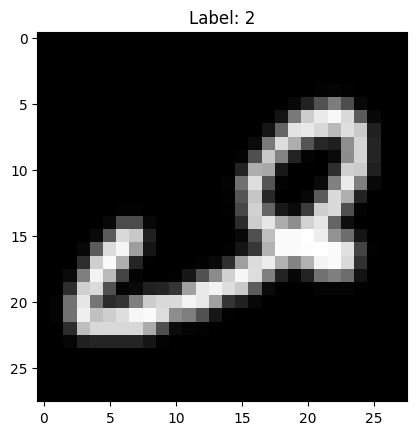

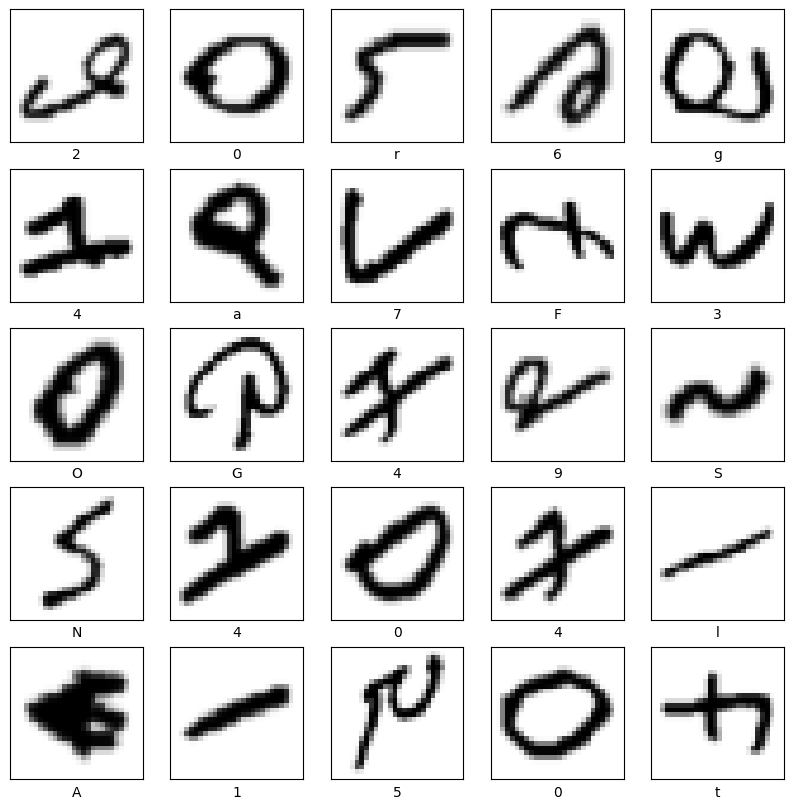

In [ ]:


# Check the contents of the directory first
print(os.listdir('/content/emnist_data/'))

# Load and preprocess data (including digits 0-9, A-Z, a-z)
train_data = pd.read_csv('/content/emnist_data/emnist-byclass-train.csv', nrows=10000)  # Limit rows for testing
test_data = pd.read_csv('/content/emnist_data/emnist-byclass-test.csv', nrows=10000)

# Separate labels and pixel data
train_labels = train_data.iloc[:, 0].values
train_images = train_data.iloc[:, 1:].values

test_labels = test_data.iloc[:, 0].values
test_images = test_data.iloc[:, 1:].values

# Reshape images to 28x28 and normalize to [0, 1]
train_images = train_images.reshape(-1, 28, 28, 1) / 255.0
test_images = test_images.reshape(-1, 28, 28, 1) / 255.0

# Filter only character and number labels (0-9, A-Z, a-z)
valid_indices = np.where((train_labels >= 0) & (train_labels <= 61))[0]
train_images = train_images[valid_indices]
train_labels = train_labels[valid_indices]

# One-hot encode the labels (now including 0-9)
train_labels = to_categorical(train_labels, num_classes=62)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Create a mapping from label index to character (including 0-9)
def index_to_char(index):
    if 0 <= index <= 9:
        return str(index)  # 0-9 digits
    elif 10 <= index <= 35:
        return chr(index + 55)  # A-Z (indices 10-35 mapped to A-Z)
    elif 36 <= index <= 61:
        return chr(index + 61)  # a-z (indices 36-61 mapped to a-z)
    return '?'  # For unknown indices

# Visualize a sample image with correct character label
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
plt.title(f"Label: {index_to_char(np.argmax(y_train[0]))}")  # Use the correct mapping
plt.show()

# Visualize multiple characters and digits (0-9, A-Z, a-z)
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10, 10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(index_to_char(np.argmax(y_train[i])))  # Use the correct mapping for label
plt.show()


# Building and Compiling a CNN Model for EMNIST Character and digit Classification (A-Z, a-z,0-9)

In [ ]:
# Function to train the model with different neuron configurations
def build_and_train_model(neurons, epochs=20):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(neurons, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout for regularization
        tf.keras.layers.Dense(62, activation='softmax')  # 62 classes (0-9, A-Z, a-z)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Measure the runtime for model training
    start_time = time.time()

    # Train the model
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=32)

    end_time = time.time()
    runtime = end_time - start_time

    # Evaluate the model on validation data
    val_loss, val_acc = model.evaluate(x_val, y_val)

    return model, history, runtime, val_loss, val_acc


In [ ]:
# Define different neuron configurations
neuron_configurations = [128, 256, 512]
epochs = 20

results = []

# Train and evaluate models with different neuron configurations
for neurons in neuron_configurations:
    model, history, runtime, val_loss, val_acc = build_and_train_model(neurons, epochs)
    results.append({
        'neurons': neurons,
        'runtime': runtime,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'history': history,
            'model': model  # Ensure this line is included
    })

# Print the structure of results to debug
print("Results Structure:", results)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.2232 - loss: 3.2229 - val_accuracy: 0.6160 - val_loss: 1.4581
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5543 - loss: 1.6480 - val_accuracy: 0.7050 - val_loss: 1.0338
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6378 - loss: 1.2575 - val_accuracy: 0.7275 - val_loss: 0.8659
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6767 - loss: 1.0740 - val_accuracy: 0.7595 - val_loss: 0.7616
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7060 - loss: 0.9743 - val_accuracy: 0.7650 - val_loss: 0.7145
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.7263 - loss: 0.8438 - val_accuracy: 0.7715 - val_loss: 0.6943
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7279 - loss: 0.8114 - val_accuracy: 0.7775 - val_loss: 0.6760
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7453 - loss: 0.7558 - val_

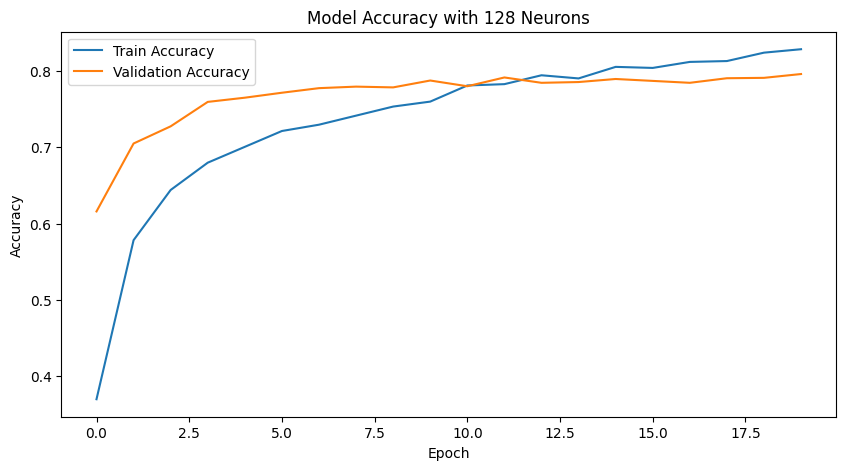

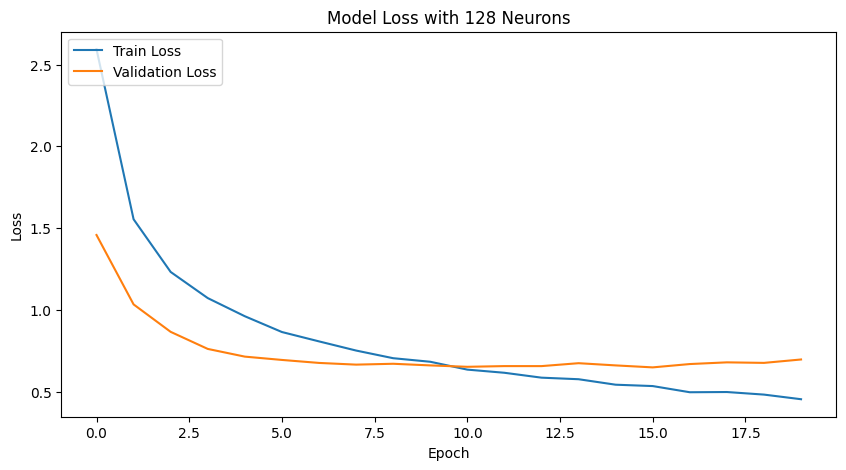

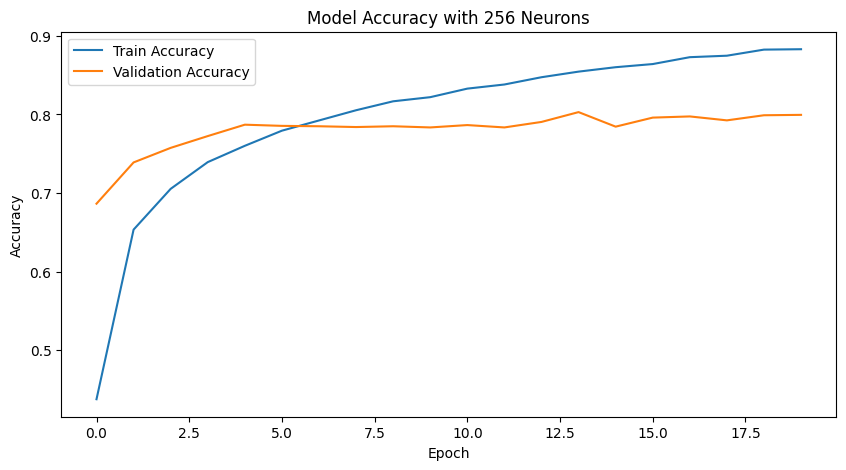

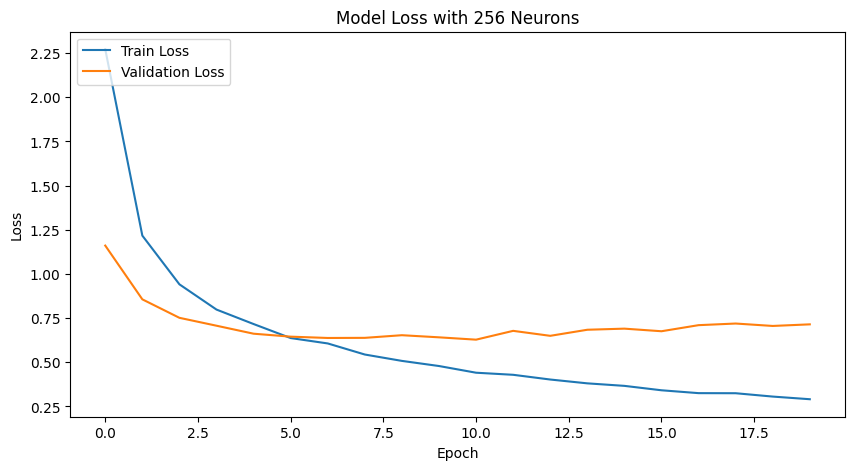

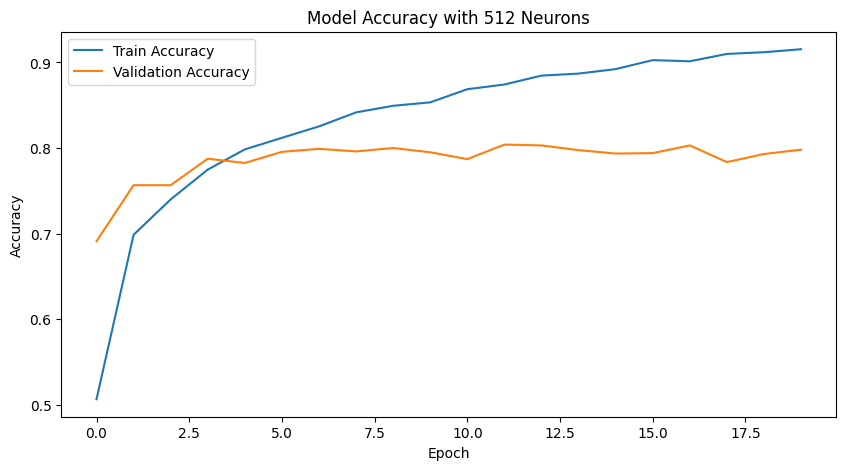

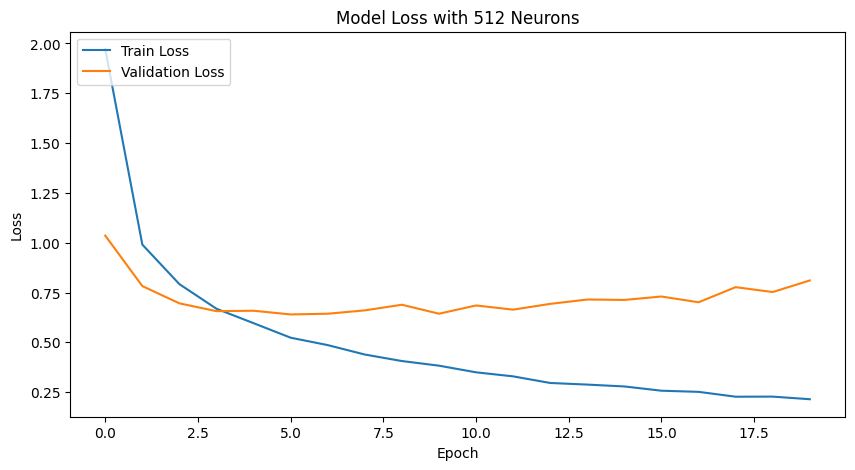

In [ ]:
# Plot performance for each configuration
for result in results:
    neurons = result['neurons']
    history = result['history']

    # Plot training & validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy with {neurons} Neurons')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss with {neurons} Neurons')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()


In [ ]:
# Display the results in a table
import pandas as pd

results_table = pd.DataFrame({
    'Neurons': [result['neurons'] for result in results],
    'Validation Accuracy': [result['val_acc'] for result in results],
    'Validation Loss': [result['val_loss'] for result in results],
    'Runtime (s)': [result['runtime'] for result in results]
})

print(results_table)


   Neurons  Validation Accuracy  Validation Loss  Runtime (s)
0      128               0.7960         0.697004   227.241387
1      256               0.7995         0.714458   253.854859
2      512               0.7980         0.810553   312.760718


# Evaluate Model on Test Data and Calculate Precision and Recall FOR CNN model

In [ ]:
# Cell 6: Evaluate Model on Test Data and Calculate Precision and Recall
# Prepare test data (similar to training)
import sklearn.metrics
# Instead of: import classification_report
from sklearn.metrics import classification_report  # Import the function from the module
test_labels = test_data.iloc[:, 0].values
test_images = test_data.iloc[:, 1:].values
test_images = test_images.reshape(-1, 28, 28, 1) / 255.0

# Filter only character and number labels (0-9, A-Z, a-z)
valid_indices = np.where((test_labels >= 0) & (test_labels <= 61))[0]
test_images = test_images[valid_indices]
test_labels = test_labels[valid_indices]

# One-hot encode the labels
test_labels_categorical = to_categorical(test_labels, num_classes=62)

# Select the last trained model (you can choose other models as needed)
final_model = results[-1]['model']

# Generate predictions
predictions = final_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate precision and recall
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=[index_to_char(i) for i in range(62)]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.66      0.66       487
           1       0.66      0.89      0.76       583
           2       0.88      0.94      0.91       497
           3       0.98      0.97      0.98       513
           4       0.90      0.94      0.92       519
           5       0.92      0.87      0.90       431
           6       0.95      0.94      0.95       471
           7       0.96      0.98      0.97       545
           8       0.94      0.95      0.94       474
           9       0.87      0.96      0.91       505
           A       0.89      0.94      0.92        90
           B       0.86      0.72      0.79        61
           C       0.75      0.85      0.80       138
           D       0.70      0.79      0.74        57
           E       0.91      0.88      0.90        78
           F       0.79      0.70      0.74       138
           G    

In [ ]:
model.save('/content/emnist_cnn_model.keras')


In [ ]:
from google.colab import files

# Path to your saved model
files.download('/content/emnist_cnn_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Building and Compiling a GRU Model for EMNIST Character and digit Classification (A-Z, a-z,0-9)

In [ ]:
from keras.layers import GRU, TimeDistributed
from sklearn.metrics import classification_report
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to build and train the CNN-GRU model
def build_and_train_gru_model(neurons, epochs=24):
    model = tf.keras.Sequential([
        # TimeDistributed CNN layers
        TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), input_shape=(1, 28, 28, 1)),
        TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))),
        TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')),
        TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))),
           # Reshape layer to convert 5D to 3D before GRU
        tf.keras.layers.Reshape((-1, 5 * 5 * 64)), # Reshape to (batch_size, timesteps, features)


        # GRU Layer for sequential processing
        GRU(units=64, return_sequences=False),  # GRU layer with 64 units

        # Fully connected layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(neurons, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout for regularization
        tf.keras.layers.Dense(62, activation='softmax')  # 62 classes (0-9, A-Z, a-z)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Measure runtime for model training
    start_time = time.time()

    # Train the model
    history = model.fit(x_train_gru, y_train, validation_data=(x_val_gru, y_val), epochs=epochs, batch_size=32)

    end_time = time.time()
    runtime = end_time - start_time

    # Evaluate the model on validation data
    val_loss, val_acc = model.evaluate(x_val_gru, y_val)

    return model, history, runtime, val_loss, val_acc

In [ ]:
neuron_configurations = [128, 256, 512]
epochs = 24

results = []
# Train and evaluate models with different neuron configurations
for neurons in neuron_configurations:
    model, history, runtime, val_loss, val_acc = build_and_train_model(neurons, epochs)
    results.append({
        'neurons': neurons,
        'runtime': runtime,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'history': history,
            'model': model  # Ensure this line is included
    })

# Print the structure of results to debug
print("Results Structure:", results)





Epoch 1/24


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.2361 - loss: 3.1965 - val_accuracy: 0.6110 - val_loss: 1.5061
Epoch 2/24
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.5658 - loss: 1.6675 - val_accuracy: 0.7160 - val_loss: 0.9996
Epoch 3/24
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.6447 - loss: 1.2653 - val_accuracy: 0.7480 - val_loss: 0.8384
Epoch 4/24
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.6770 - loss: 1.0582 - val_accuracy: 0.7615 - val_loss: 0.7550
Epoch 5/24
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.7031 - loss: 0.9442 - val_accuracy: 0.7660 - val_loss: 0.7098
Epoch 6/24
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7369 - loss: 0.8048 - val_accuracy: 0.7685 - val_loss: 0.6740
Epoch 7/24
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7367 - loss: 0.7946 - val_accuracy: 0.7730 - val_loss: 0.6493
Epoch 8/24
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7530 - loss: 0.7309 - val_accuracy:

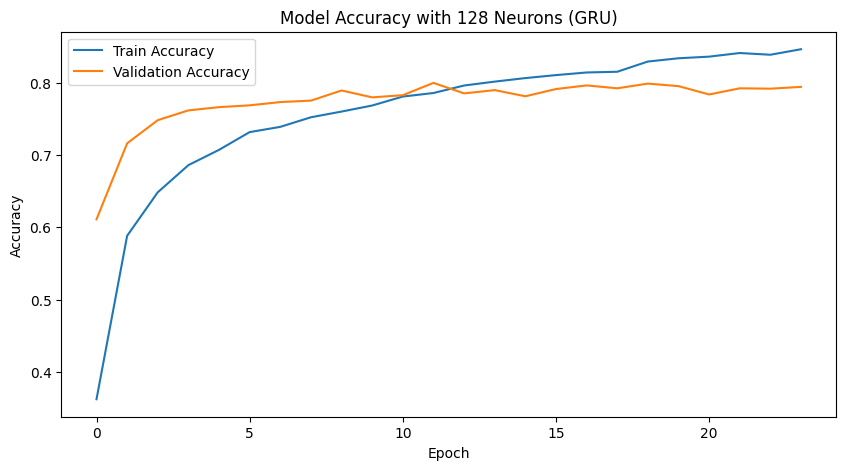

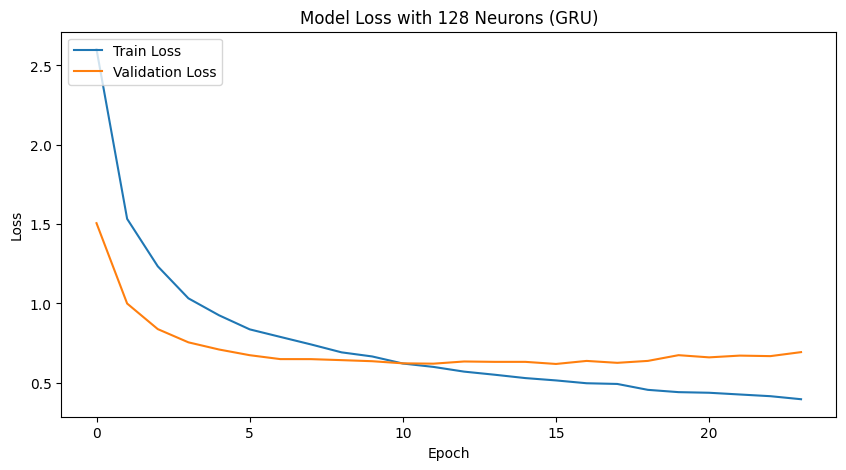

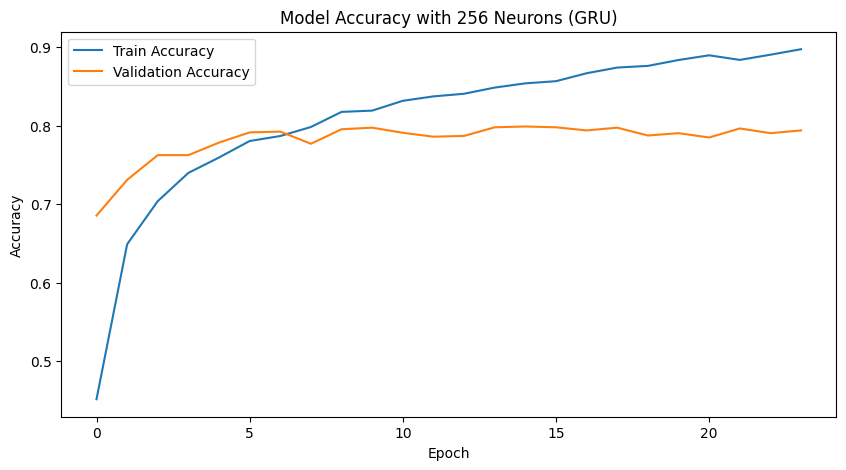

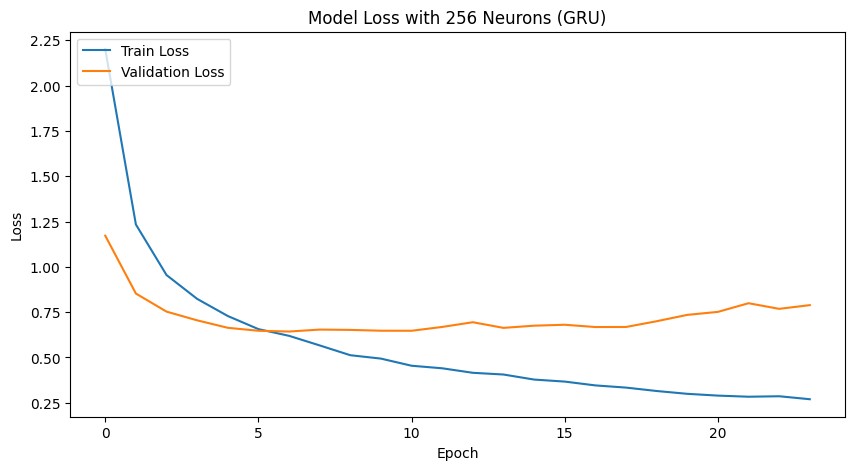

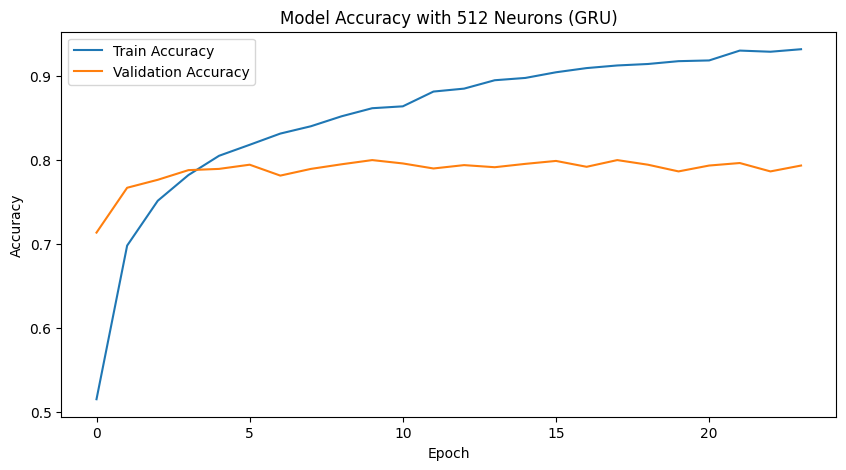

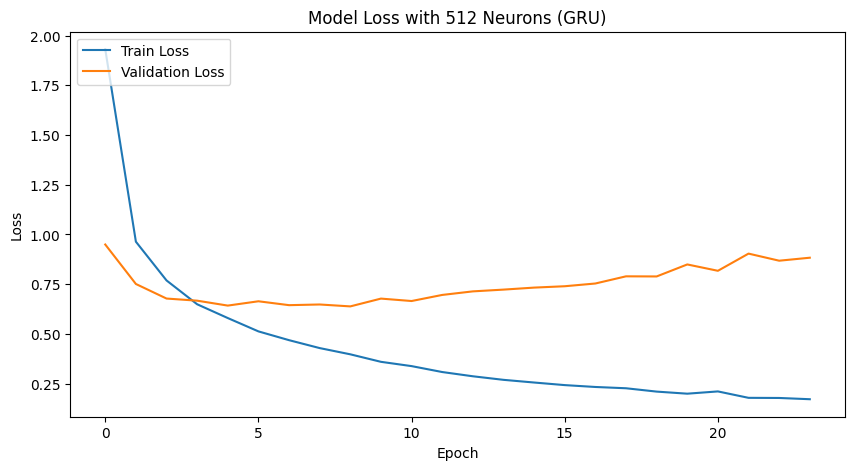

In [ ]:
for result in results:
    neurons = result['neurons']
    history = result['history']

    # Plot training & validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy with {neurons} Neurons (GRU)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss with {neurons} Neurons (GRU)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()


In [ ]:
results_table = pd.DataFrame({
    'Neurons': [result['neurons'] for result in results],
    'Validation Accuracy': [result['val_acc'] for result in results],
    'Validation Loss': [result['val_loss'] for result in results],
    'Runtime (s)': [result['runtime'] for result in results]
})

print(results_table)

   Neurons  Validation Accuracy  Validation Loss  Runtime (s)
0      128               0.7940         0.693301   273.573292
1      256               0.7940         0.788384   306.706496
2      512               0.7935         0.883038   360.433946


# Evaluate the Final Model on Test Data and Calculate Precision and Recall for GRU MODEL

In [ ]:
# Cell 6: Evaluate the Final Model on Test Data and Calculate Precision and Recall

# Prepare test data (reshape similar to training)
test_images_gru = test_images.reshape(test_images.shape[0], 1, 28, 28, 1)  # Add time step dimension

# Select the last trained model (or you can choose any model)
final_model = results[-1]['model']

# Generate predictions
predictions = final_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Filter only character and number labels (0-9, A-Z, a-z)
valid_indices = np.where((test_labels >= 0) & (test_labels <= 61))[0]
test_images = test_images[valid_indices]
test_labels = test_labels[valid_indices]

# One-hot encode the labels for 62 classes
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=62)

# Generate classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=[index_to_char(i) for i in range(62)]))


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.80      0.69       487
           1       0.66      0.88      0.76       583
           2       0.89      0.94      0.91       497
           3       0.95      0.99      0.97       513
           4       0.89      0.92      0.91       519
           5       0.89      0.90      0.89       431
           6       0.91      0.96      0.94       471
           7       0.95      0.99      0.97       545
           8       0.96      0.92      0.94       474
           9       0.85      0.94      0.90       505
           A       0.88      0.83      0.86        90
           B       0.94      0.74      0.83        61
           C       0.76      0.72      0.74       138
           D       0.80      0.68      0.74        57
           E       0.92      0.83      0.87        78
           F       0.75      0.80      0.77       138
           G    

# Building and Compiling a HYBRID CONVLSTM Model for EMNIST Character Classification (A-Z, a-z,0-9)


In [ ]:
  # Import necessary layers for ConvLSTM
  from keras.layers import ConvLSTM2D, TimeDistributed
  from sklearn.metrics import classification_report
  import time
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt

  # Function to train the ConvLSTM model with different neuron configurations
  def build_and_train_convlstm_model(neurons, epochs=20):
      model = tf.keras.Sequential([
          # Reshape input to have a time step dimension (needed for ConvLSTM)
          TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), input_shape=(1, 28, 28, 1)),
          TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))),
          TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')),
          TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))),

          # ConvLSTM Layer for spatio-temporal learning
          ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', return_sequences=False),

          # Flatten and Dense Layers
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(neurons, activation='relu'),
          tf.keras.layers.Dropout(0.5),  # Dropout for regularization
          tf.keras.layers.Dense(62, activation='softmax')  # 62 classes (0-9, A-Z, a-z)
      ])

      # Compile the model
      model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

      # Measure runtime for model training
      start_time = time.time()

      # Train the model
      history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=32)

      end_time = time.time()
      runtime = end_time - start_time

      # Evaluate the model on validation data
      val_loss, val_acc = model.evaluate(x_val, y_val)

      return model, history, runtime, val_loss, val_acc


In [ ]:
neuron_configurations = [128, 256, 512]
epochs = 20

results = []
# Train and evaluate models with different neuron configurations
for neurons in neuron_configurations:
    model, history, runtime, val_loss, val_acc = build_and_train_model(neurons, epochs)
    results.append({
        'neurons': neurons,
        'runtime': runtime,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'history': history,
            'model': model  # Ensure this line is included
    })

# Print the structure of results to debug
print("Results Structure:", results)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.2395 - loss: 3.1537 - val_accuracy: 0.6525 - val_loss: 1.3385
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5990 - loss: 1.4951 - val_accuracy: 0.7255 - val_loss: 0.9439
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.6570 - loss: 1.1482 - val_accuracy: 0.7580 - val_loss: 0.7896
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6972 - loss: 0.9681 - val_accuracy: 0.7610 - val_loss: 0.7443
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.7192 - loss: 0.9025 - val_accuracy: 0.7690 - val_loss: 0.6925
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.7511 - loss: 0.7541 - val_accuracy: 0.7790 - val_loss: 0.6646
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7516 - loss: 0.7259 - val_accuracy: 0.7790 - val_loss: 0.6682
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7739 - loss: 0.6714 - val_accuracy

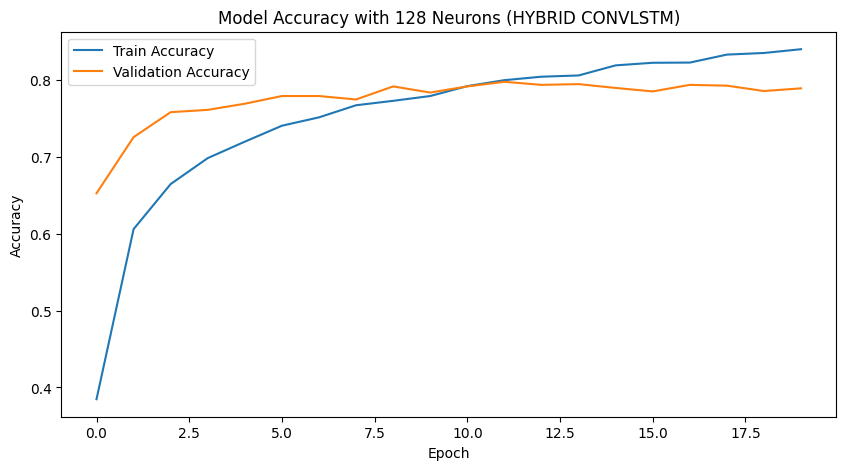

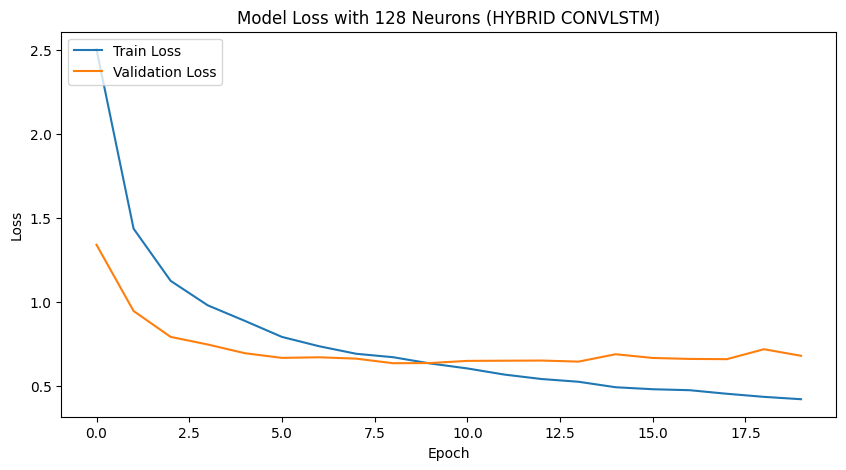

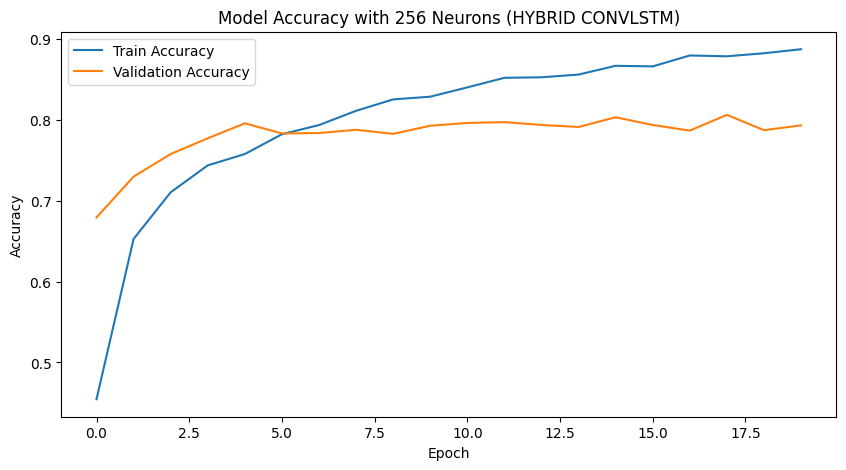

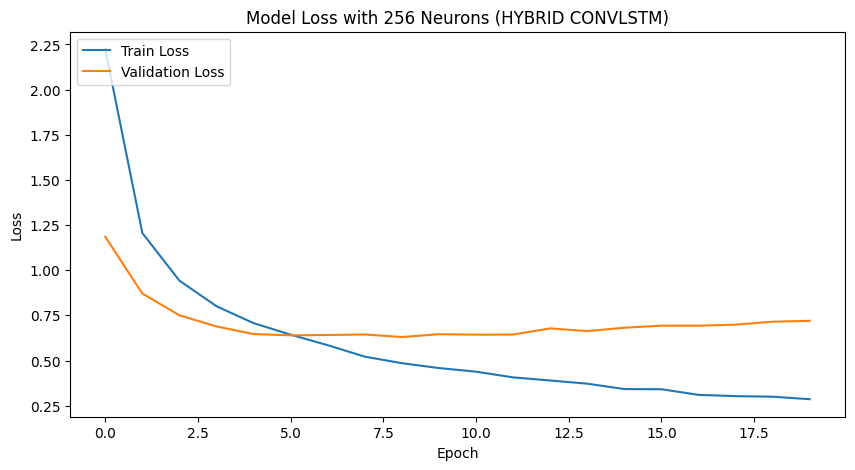

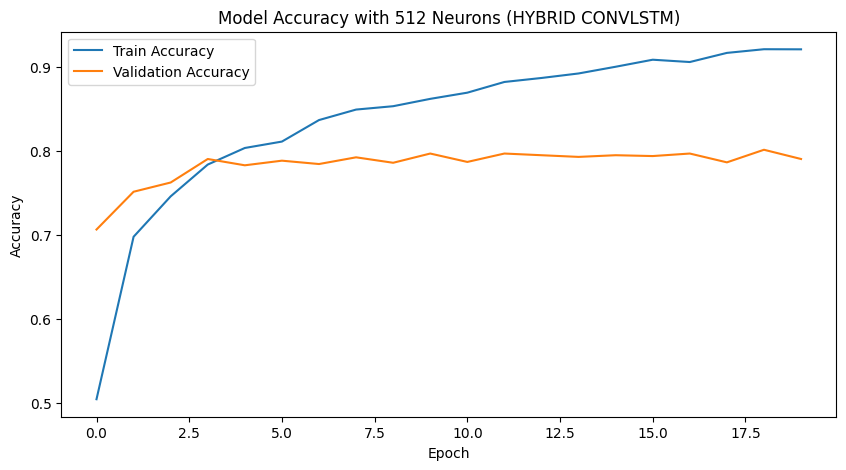

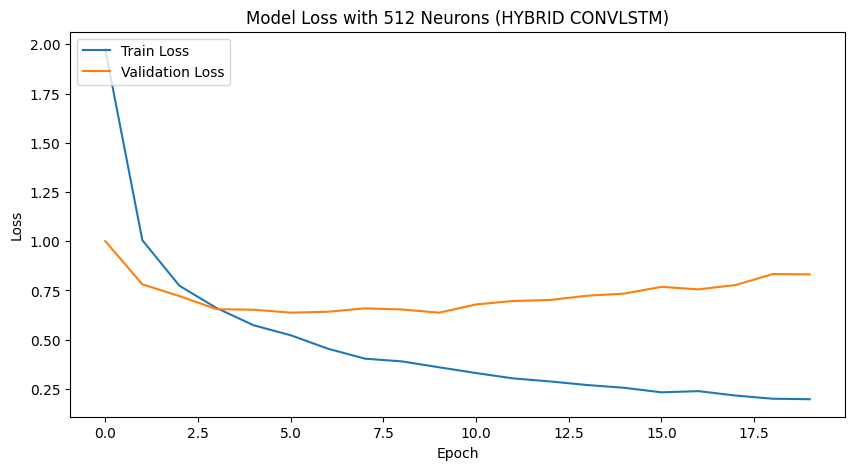

In [ ]:
for result in results:
    neurons = result['neurons']
    history = result['history']

    # Plot training & validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy with {neurons} Neurons (HYBRID CONVLSTM)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss with {neurons} Neurons (HYBRID CONVLSTM)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()


In [ ]:
results_table = pd.DataFrame({
    'Neurons': [result['neurons'] for result in results],
    'Validation Accuracy': [result['val_acc'] for result in results],
    'Validation Loss': [result['val_loss'] for result in results],
    'Runtime (s)': [result['runtime'] for result in results]
})

print(results_table)

   Neurons  Validation Accuracy  Validation Loss  Runtime (s)
0      128               0.7890         0.677009   210.080498
1      256               0.7935         0.719724   256.612032
2      512               0.7905         0.831367   275.142332


# Evaluate the Final Model on Test Data and Calculate Precision and Recall for HYBRID CONVLSTM

In [ ]:
# Cell 6: Evaluate the Final Model on Test Data and Calculate Precision and Recall

# Prepare test data (reshape similar to training)
test_images_gru = test_images.reshape(test_images.shape[0], 1, 28, 28, 1)  # Add time step dimension

# Select the last trained model (or you can choose any model)
final_model = results[-1]['model']

# Generate predictions
predictions = final_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Filter only character and number labels (0-9, A-Z, a-z)
valid_indices = np.where((test_labels >= 0) & (test_labels <= 61))[0]
test_images = test_images[valid_indices]
test_labels = test_labels[valid_indices]

# One-hot encode the labels for 62 classes
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=62)

# Generate classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=[index_to_char(i) for i in range(62)]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.64       487
           1       0.66      0.90      0.76       583
           2       0.85      0.97      0.91       497
           3       0.98      0.98      0.98       513
           4       0.87      0.96      0.91       519
           5       0.90      0.88      0.89       431
           6       0.93      0.96      0.94       471
           7       0.96      0.98      0.97       545
           8       0.95      0.93      0.94       474
           9       0.88      0.92      0.90       505
           A       0.89      0.84      0.87        90
           B       0.86      0.79      0.82        61
           C       0.75      0.86      0.80       138
           D       0.73      0.70      0.71        57
           E       0.97      0.78      0.87        78
           F       0.80      0.83      0.81       138
           G    

# Building and Compiling a LENET50 Model for EMNIST Character Classification (A-Z, a-z,0-9)

In [ ]:
# Function to train the LeNet-5 model with different neuron configurations
def build_and_train_lenet_model(neurons, epochs=20):
    model = tf.keras.Sequential([
        # First set of layers: Convolution + Average Pooling
        Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1)),
        AveragePooling2D(pool_size=(2, 2)),

        # Second set of layers: Convolution + Average Pooling
        Conv2D(16, (5, 5), activation='relu'),
        AveragePooling2D(pool_size=(2, 2)),

        # Flatten and fully connected layers
        Flatten(),
        Dense(120, activation='relu'),
        Dense(neurons, activation='relu'),  # Vary the neurons here
        Dropout(0.5),  # Dropout for regularization
        Dense(62, activation='softmax')  # 62 classes (0-9, A-Z, a-z)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Measure runtime for model training
    start_time = time.time()

    # Train the model
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=32)

    end_time = time.time()
    runtime = end_time - start_time

    # Evaluate the model on validation data
    val_loss, val_acc = model.evaluate(x_val, y_val)

    return model, history, runtime, val_loss, val_acc


# Train Models with Different Neuron Configurations

In [ ]:
# Define different neuron configurations
neuron_configurations = [128, 256, 512]
epochs = 20

results = []

# Train and evaluate models with different neuron configurations
for neurons in neuron_configurations:
    model, history, runtime, val_loss, val_acc = build_and_train_model(neurons, epochs)
    results.append({
        'neurons': neurons,
        'runtime': runtime,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'history': history,
        'model': model
    })

# Print the structure of results to debug
print("Results Structure:", results)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.2315 - loss: 3.2339 - val_accuracy: 0.6055 - val_loss: 1.4380
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.5614 - loss: 1.6791 - val_accuracy: 0.7050 - val_loss: 1.0125
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.6204 - loss: 1.2872 - val_accuracy: 0.7365 - val_loss: 0.8602
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6802 - loss: 1.0696 - val_accuracy: 0.7650 - val_loss: 0.7759
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7074 - loss: 0.9383 - val_accuracy: 0.7640 - val_loss: 0.7179
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.7280 - loss: 0.8409 - val_accuracy: 0.7805 - val_loss: 0.6770
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7384 - loss: 0.7694 - val_accuracy: 0.7800 - val_loss: 0.6656
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7504 - loss: 0.7432 - val_accuracy: 

KeyboardInterrupt: 

# Plot Training and Validation Accuracy and Loss

In [ ]:
# Plot performance for each configuration
for result in results:
    neurons = result['neurons']
    history = result['history']

    # Plot training & validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'LeNet-5 Model Accuracy with {neurons} Neurons')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'LeNet-5 Model Loss with {neurons} Neurons')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()


# Display Summary of Results

In [ ]:
# Display the results in a table
results_table = pd.DataFrame({
    'Neurons': [result['neurons'] for result in results],
    'Validation Accuracy': [result['val_acc'] for result in results],
    'Validation Loss': [result['val_loss'] for result in results],
    'Runtime (s)': [result['runtime'] for result in results]
})

print(results_table)


# Test the Model and Evaluate Precision, Recall, and F1-Score

In [ ]:
# Prepare test data (similar to training)
test_labels = test_data.iloc[:, 0].values
test_images = test_data.iloc[:, 1:].values
test_images = test_images.reshape(-1, 28, 28, 1) / 255.0

# Filter only character and number labels (0-9, A-Z, a-z)
valid_indices = np.where((test_labels >= 0) & (test_labels <= 61))[0]
test_images = test_images[valid_indices]
test_labels = test_labels[valid_indices]

# One-hot encode the labels
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=62)

# Select the last trained model (you can choose other models as needed)
final_model = results[-1]['model']

# Generate predictions
predictions = final_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate precision and recall
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=[index_to_char(i) for i in range(62)]))


# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[index_to_char(i) for i in range(62)],
            yticklabels=[index_to_char(i) for i in range(62)])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# Bar Chart for Precision and Recall

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predicted_labels, average=None)

# Prepare labels (labeled values)
labels = [index_to_char(i) for i in range(62)]

# Number of labeled samples for each class (optional, you can adjust if you have specific counts)
labeled_samples = np.array([np.sum(test_labels == i) for i in range(62)])

# Plot precision and recall with labeled samples in a bar chart
fig, ax = plt.subplots(figsize=(14, 7))

# Plot precision as the first bar for detection rate
ax.bar(np.arange(len(labels)) - 0.3, precision, 0.3, label='Precision (Detection)', color='blue')

# Plot recall as the second bar for detection rate
ax.bar(np.arange(len(labels)), recall, 0.3, label='Recall (Detection)', color='orange')

# Plot labeled samples for each class
ax.bar(np.arange(len(labels)) + 0.3, labeled_samples / np.max(labeled_samples), 0.3, label='Labeled Samples', color='green')

# Set chart labels and title
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_xlabel('Labeled Classes (Characters and Digits)')
ax.set_ylabel('Score / Detection Rate')
ax.set_title('Detection Values (Precision and Recall) with Labeled Samples')
ax.legend()

plt.show()

In [ ]:
! pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.7 MB/s eta 0:00:00


In [ ]:
# ============================
# CONTINUATION: IMAGE UPLOAD + PREDICTION
# ============================

import numpy as np
import streamlit as st
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import io
import cv2
import streamlit as st

# -----------------------------
# Streamlit Handwritten Recognition App
# -----------------------------
st.title("🧠 Handwritten Digit/Character Recognition using GRU Model")

st.write("""
Upload an image of a handwritten **digit or character**.
The app will preprocess it and use your trained GRU model to predict the correct output.
""")

# Upload image
uploaded_file = st.file_uploader("Upload a handwritten image (jpg/png)", type=["jpg", "jpeg", "png"])

# Preprocessing function
def preprocess_image(img, target_size=(28, 28)):
    # Convert to grayscale
    img = img.convert("L")

    # Resize to match model input
    img = img.resize(target_size)

    # Convert to numpy array
    img_array = np.array(img)

    # Invert colors if background is dark
    if np.mean(img_array) < 128:
        img_array = 255 - img_array

    # Normalize to [0,1]
    img_array = img_array / 255.0

    # For GRU, reshape to (1, timesteps, features)
    img_array = img_array.reshape(1, target_size[0], target_size[1], 1) # Add channel dimension

    return img_array

# If image uploaded
if uploaded_file is not None:
    # Open and display the image
    img = Image.open(uploaded_file)
    st.image(img, caption="Uploaded Image", use_column_width=True)

    # Preprocess
    processed = preprocess_image(img, target_size=(28, 28))

    # Predict using GRU model
    st.write("🔍 Predicting...")
    try:
        # Ensure the 'model' variable exists and is the desired GRU model
        if 'model' in globals() and isinstance(model, tf.keras.Model):
            pred = model.predict(processed)
            predicted_class = np.argmax(pred)
            st.success(f"✅ Predicted Output: {predicted_class}")

            # Optionally show probabilities
            st.bar_chart(pred[0])
        else:
            st.error("Error: GRU model not found. Please make sure the GRU model is trained and the variable is named 'model'.")

    except Exception as e:
        st.error(f"Error during prediction: {e}")

st.write("---")
st.info("Make sure your trained GRU model variable is named **model** in this notebook.")

2025-10-22 10:48:36.811 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:48:36.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:48:36.814 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:48:36.819 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:48:36.822 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:48:36.825 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:48:36.831 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:48:36.836 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()